In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast
import json
import os
from tqdm import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
import re

In [43]:
gtzan_bind = pd.read_csv('dataset/seungheondoh/gtzan-bind/gtzan_bind_v1.csv')
# gtzan_bind

In [44]:
gtzan_artist2music = pd.read_csv('dataset/seungheondoh/gtzan_retrieval/artist2music.csv')
# gtzan_artist2music

In [45]:
gtzan_bind_artist = gtzan_bind['artist_name'].to_list()
gtzan_artist2music_artist = gtzan_artist2music['query'].to_list()

In [46]:
def CompareAtoB(list_a, list_b):
    for i, name in enumerate(list_a):
        if name not in list_b:
            print(i, name)

print('Exists in bind, not in artist2music')
CompareAtoB(gtzan_bind_artist, gtzan_artist2music_artist)
print('-' * 30)
print('Exists in artist2music, not in bind')
CompareAtoB(gtzan_artist2music_artist, gtzan_bind_artist)

Exists in bind, not in artist2music
82 nan
86 nan
152 Billy Joe Shaver
248 nan
360 nan
379 nan
448 Johnny Crass
479 Diana Ross
560 nan
567 Sonny Throckmorton
694 nan
701 nan
707 Wesley Dennis
723 Erik Satie
726 nan
847 nan
853 Deep Purple
886 nan
894 nan
943 nan
957 Normaltown Flyers
993 nan
------------------------------
Exists in artist2music, not in bind


In [47]:
count_retrieval_task_n = 0
for idx_list in gtzan_artist2music['target_idx'].apply(ast.literal_eval):
    count_retrieval_task_n += len(idx_list)
count_retrieval_task_n

974

In [48]:
corpus = [json.loads(line) for line in open('dataset/music_corpus.jsonl')]
corpus_text_list = [element['text'] for element in corpus]

In [49]:
set([element['source'] for element in corpus])

{'allmusic',
 'amazon_review',
 'lp_music_caps',
 'ner',
 'pitchfork',
 'song_meaning',
 'wikipedia'}

In [51]:
search_list = ['artist'] # TODO(minheelee): Change to get this by command line?
RESULT_DIR = Path(f'result')
for search in search_list:
    result_file_path = RESULT_DIR / Path(f'{search}_counted_by_regex.csv')

    # count
    if not result_file_path.exists():
        base_file_path = Path(f'dataset/seungheondoh/gtzan_retrieval/{search}2music.csv')
        assert base_file_path.exists(), f'{base_file_path} does not exist'
        base_df = pd.read_csv(base_file_path)

        result_dict = defaultdict(dict)
        for query in tqdm(base_df['query']):
            pattern = r'\b' + re.escape(query) + r'\b'

            total_occurance = 0
            n_of_entity = 0
            for text in corpus_text_list:
                count = len(re.findall(pattern, text))
                if count != 0:
                    total_occurance += count
                    n_of_entity += 1
            
            result_dict['num_of_occurances'][query] = total_occurance
            result_dict['num_of_documents'][query] = n_of_entity

        result_df = pd.DataFrame(result_dict)
        result_df.index.name = 'query'

        # get number of targets per artist
        base_df['target_idx'] = base_df['target_idx'].apply(ast.literal_eval)
        num_of_targets = [len(element) for element in base_df['target_idx'].to_list()]
        result_df['num_of_targets'] = num_of_targets
    else:
        result_df = pd.read_csv(result_file_path)

    # sort
    result_df.sort_values(by = 'num_of_occurances', ascending = False, inplace = True)
    print(search)
    display(result_df)
    result_df.to_csv(result_file_path)
    print('-' * 30)


artist


,query,num_of_occurances,num_of_documents,num_of_targets
0,New York City,112968,90027,1
1,Queen,110206,57753,14
2,Madonna,42190,17515,4
3,Metallica,33857,15804,7
4,Led Zeppelin,25668,14752,11
...,...,...,...,...
271,E. Power Biggs & Vittorio Negri,0,0,1
272,Don Armando's 2nd Ave. Rhumba Band,0,0,1
273,Disco-Tex & His Sex-O-Lettes,0,0,1
274,Dirt featuring Epsilon,0,0,1


------------------------------


* Ranges are in intervals of 10,000 *
[110,000, 120,000): 2, 2
[40,000, 50,000): 1, 3
[30,000, 40,000): 1, 4
[20,000, 30,000): 5, 9
[10,000, 20,000): 23, 32
------------------------------
* Ranges are in intervals of 1,000 *
[9,000, 10,000): 5, 37
[8,000, 9,000): 3, 40
[7,000, 8,000): 8, 48
[6,000, 7,000): 5, 53
[5,000, 6,000): 16, 69
[4,000, 5,000): 19, 88
[3,000, 4,000): 16, 104
[2,000, 3,000): 24, 128
[1,000, 2,000): 27, 155
------------------------------
* Ranges are in intervals of 100 *
[900, 1,000): 5, 160
[800, 900): 7, 167
[700, 800): 5, 172
[600, 700): 4, 176
[500, 600): 3, 179
[400, 500): 9, 188
[300, 400): 6, 194
[200, 300): 12, 206
[100, 200): 10, 216
[0, 100): 97, 313


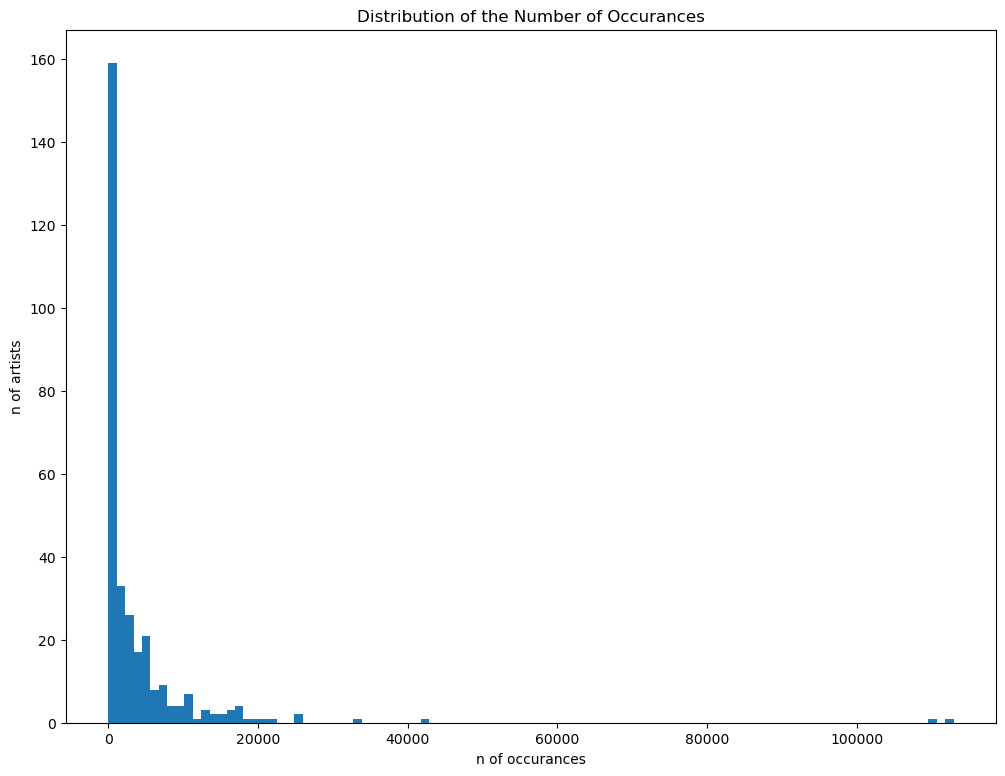

In [53]:
def make_number_prettier(number: int):
    number = str(number)
    

for search in search_list:
    result_file_path = RESULT_DIR / Path(f'{search}_counted_by_regex.csv')
    assert result_file_path.exists()
    result_df = pd.read_csv(result_file_path)

    # get the number of elements per range
    result_total_list = np.array(result_df['num_of_occurances'].to_list())
    unit = int(1e4)
    print(f'* Ranges are in intervals of {unit:,} *')
    range_max = int((max(result_total_list) // unit + 1) * unit)
    while range_max > 0:
        assert unit > 0, f'unit should be bigger than 0, now {unit}'

        range_min = range_max - unit
        count_in_range = np.sum((range_min <= result_total_list) & (result_total_list < range_max))
        count_accumulated = np.sum((range_min <= result_total_list))
        if count_in_range > 0:
            print(f'[{range_min:,}, {range_max:,}): {count_in_range:,}, {count_accumulated:,}')

        range_max = range_min
        if range_max == 10000 or range_max == 1000:
            unit = unit // 10
            print('-' * 30)
            print(f'* Ranges are in intervals of {unit:,} *')

    # draw histogram
    plt.figure(figsize = (12, 9))
    plt.hist(result_total_list, bins = 100)
    plt.title('Distribution of the Number of Occurances')
    plt.xlabel('n of occurances')
    plt.ylabel('n of artists')
    plt.show()